In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ngram
import re
import string
import nltk
from nltk.util import ngrams
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
from collections import Counter

In [4]:
data = pd.read_csv('./GrammarandProductReviews.csv')

In [5]:
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


In [4]:
list(data.columns)

['id',
 'brand',
 'categories',
 'dateAdded',
 'dateUpdated',
 'ean',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'name',
 'reviews.date',
 'reviews.dateAdded',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.userCity',
 'reviews.userProvince',
 'reviews.username',
 'upc']

In [5]:
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating
count,3.215800e+04,32508.000000,71044.000000
mean,7.944753e+07,0.410422,4.385747
std,4.842696e+07,3.574442,1.067659
min,2.187400e+04,0.000000,1.000000
25%,3.355342e+07,0.000000,4.000000
50%,7.124763e+07,0.000000,5.000000
75%,1.112628e+08,0.000000,5.000000
max,1.038227e+09,183.000000,5.000000


(array([ 3701.,     0.,  1833.,     0.,     0.,  4369.,     0., 14598.,
            0., 46543.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

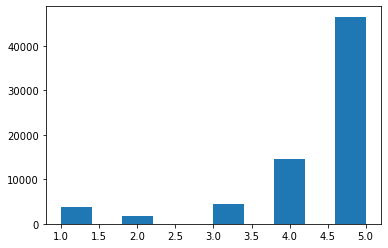

In [6]:
plt.hist(data['reviews.rating'])

Podemos observar que hay 25 columnas en el dataset. De estas, solo reviews.id, reviews.numHelpful y reviews.rating son numéricas. Podemos observar además que, dado que la mediana de reviews.rating es 5 y que el promedio es 4.38, que más de la mitad de reseñas son de 5 estrellas, y al menos un 75% del dataset tiene reseñas por encima de 4 estrellas.
Por otro lado, parece que poca gente indica si una reseña de alguien más es útil.

Con los ratings (e incluso los títulos), ya se puede tener una idea del contenido del review.

Se buscará quitar las stops words que puedan involucrar en que la frase se convierta en neutra, así que quitaremos contracciones para comprender de mejor manera el texto.

In [7]:
# Contraction Map
# Diccionario de contracciones
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# Funcion que busca alguna contraccion en el diccionario y la expande la contraccion
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        print('type EC',type(expanded_contraction), expanded_contraction)
        return expanded_contraction
    try:
        expanded_text = contractions_pattern.sub(expand_match, text)
    except:
        print("failed text: ", text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
import re
import numpy as np
import string

# Limpieza de datos con regex y string.punctuation
REPLACE_NO_SPACE = re.compile(r"[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile(r"(<br\s*/><br\s*/>)|(\-)|(\/)(.)")

def RemoveWithRegex(words):
    x = np.copy(words)
    punctuation = r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for i in range(len(x)):
        x[i] = REPLACE_NO_SPACE.sub("", str(x[i]))
        x[i] = REPLACE_WITH_SPACE.sub(" ", str(x[i]))
        x[i] = "".join(filter(lambda x: not x.isdigit(), x[i])) # Quitar digitos
        x[i] = expand_contractions(x[i])
        x[i] = ' '.join(word.strip(string.punctuation) for word in x[i].split()) # última línea de defensa
    return x

In [9]:
# Convertir columnas necesarios a minusculas
data['reviews.text'] = data['reviews.text'].str.lower()
data['reviews.title'] = data['reviews.title'].str.lower()

In [12]:
# Limpieza de datos con funcion antes declarada
data['reviews.text'] = RemoveWithRegex(np.asarray(data['reviews.text']))
data['reviews.title'] = RemoveWithRegex(np.asarray(data['reviews.title']))

In [13]:
english_stop_words = stopwords.words('english')
english_stop_words.remove('no')
english_stop_words.remove('not')

# Funcion que elimina stop words, sin palabras como 'no' y 'not'
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

In [20]:
# Se remueven las stop words de las columnas a estudiar
data['reviews.text'] = remove_stop_words(np.asarray(data['reviews.text']))
data['reviews.title'] = remove_stop_words(np.asarray(data['reviews.title']))

Ya que hemos limpiado el texto de las reseñas y los títulos de las mismas, vale la pena evaluar cuáles son las palabras más usadas. Además, esto se hará distinguiendo con respecto al rating otorgado.

In [61]:
# Separacion de los reviews en los diferentes ratings posibles
rated_1 = data[data['reviews.rating'] == 1]
rated_2 = data[data['reviews.rating'] == 2]
rated_3 = data[data['reviews.rating'] == 3]
rated_4 = data[data['reviews.rating'] == 4]
rated_5 = data[data['reviews.rating'] == 5]

In [22]:
rated_1

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,read reviews looking buying one couples lubric...,disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,husband bought gel us gel caused irritation fe...,irritation,NaN,NaN,Walker557,67981934427
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,149773828.0,NaN,1,https://www.walmart.com/reviews/product/43383370,boyfriend bought spice things bedroom highly d...,not worth,NaN,NaN,Samantha,67981934427
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,129088591.0,NaN,1,https://www.walmart.com/reviews/product/43383370,bought earlier today excited check based produ...,disappointing,NaN,NaN,Raeanne,67981934427
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,131769441.0,NaN,1,https://www.walmart.com/reviews/product/43383370,bought product husband try not impressed no ti...,not happy,NaN,NaN,Kimmie,67981934427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70841,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,129763996.0,NaN,1,https://www.walmart.com/reviews/product/450239...,causes red eyes every time use ithe disappoint...,feels nice causes red eyes every time,NaN,NaN,Ndjames5,"300650361040,631113253665,300650193108,3006503..."
70842,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,95579053.0,NaN,1,https://www.walmart.com/reviews/product/450239...,hours rinsing lenses product leaves greasy fil...,not best opti free product,NaN,NaN,Babola,"300650361040,631113253665,300650193108,3006503..."
70843,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,...,67933930.0,1.0,1,https://www.walmart.com/reviews/product/12169288,ive tired opti free pure moist im allergic opt...,worst contact soultion brand,NaN,NaN,Trouble41267,"300650361040,631113253665,300650193108,3006503..."
70844,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T1

## Frecuencia de palabras

### Rating = 1

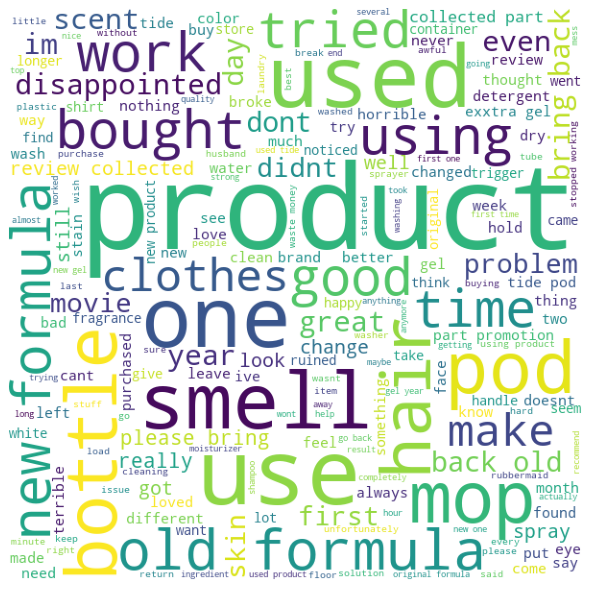

In [62]:
# Frecuencia de palabras
# Wordcloud de las palabras de rating = 1
words = ' '.join(rated_1['reviews.text'])

wordcloud = WordCloud(width = 600,
                      height = 600,
                      background_color ='white'
                    ).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [63]:
words_ = words.split()
counts = Counter(words_)

# función que calcula la cantidad de veces que aparece cada palabra en el dataset. 
def word_counter(cleaned_words):
    word_counter = {}
    for word in cleaned_words:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    return word_counter

word_counter = word_counter(words_)

word_counter_sorted_1 = sorted(word_counter.items(), key=lambda x:x[1],reverse=True)

word_dict_1 = dict(word_counter_sorted_1[0:10])

<BarContainer object of 10 artists>

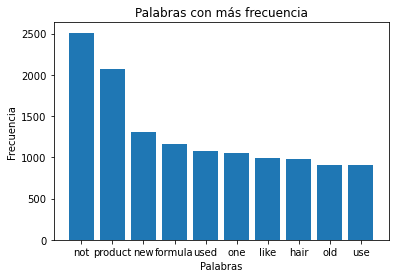

In [64]:
# Histograma de palabras mas frecuentes
keys = word_dict_1.keys()
values = word_dict_1.values()
plt.title("Palabras con más frecuencia")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

### Rating = 2

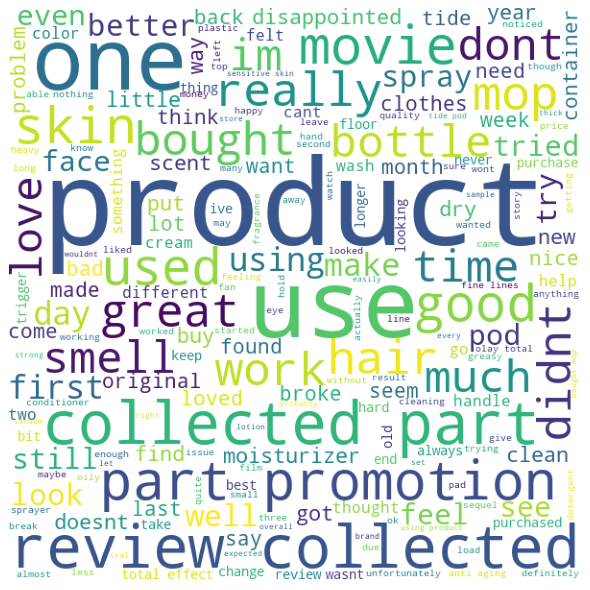

In [65]:
# Frecuencia de palabras
# Wordcloud de las palabras de rating = 2
words = ' '.join(rated_2['reviews.text'])

wordcloud = WordCloud(width = 600,
                      height = 600,
                      background_color ='white'
                    ).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

<BarContainer object of 10 artists>

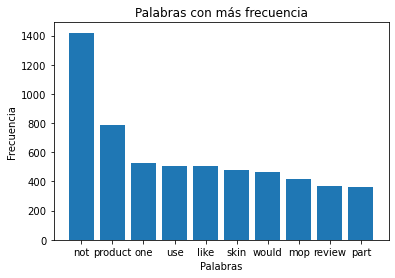

In [66]:
words_ = words.split()
counts = Counter(words_)

# función que calcula la cantidad de veces que aparece cada palabra en el dataset. 
def word_counter(cleaned_words):
    word_counter = {}
    for word in cleaned_words:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    return word_counter


# Histograma de palabras mas frecuentes
word_counter = word_counter(words_)

word_counter_sorted_2 = sorted(word_counter.items(), key=lambda x:x[1],reverse=True)

word_dict_2 = dict(word_counter_sorted_2[0:10])
keys = word_dict_2.keys()
values = word_dict_2.values()
plt.title("Palabras con más frecuencia")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

### Rating = 3

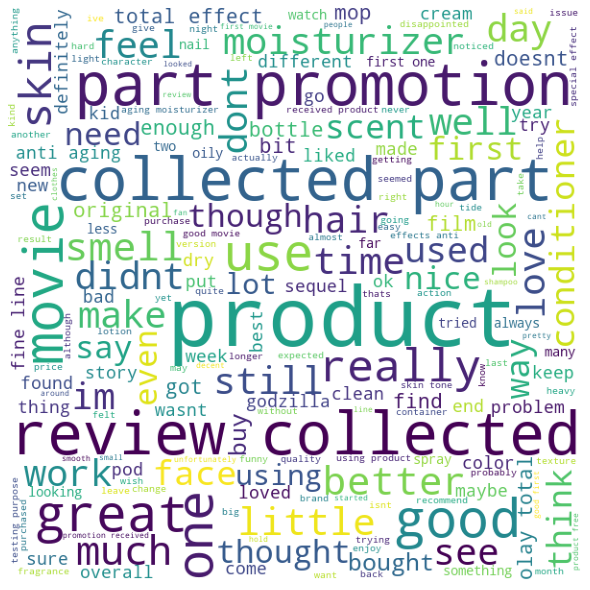

In [67]:
# Frecuencia de palabras
# Wordcloud de las palabras de rating = 3
words = ' '.join(rated_3['reviews.text'])

wordcloud = WordCloud(width = 600,
                      height = 600,
                      background_color ='white'
                    ).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

<BarContainer object of 10 artists>

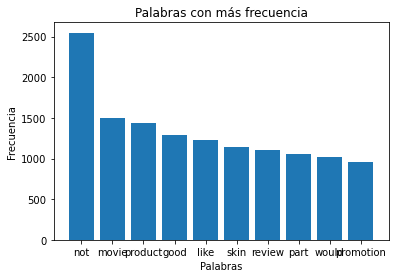

In [68]:
words_ = words.split()
counts = Counter(words_)

# función que calcula la cantidad de veces que aparece cada palabra en el dataset. 
def word_counter(cleaned_words):
    word_counter = {}
    for word in cleaned_words:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    return word_counter

# Histograma de palabras mas frecuentes
word_counter = word_counter(words_)

word_counter_sorted_3 = sorted(word_counter.items(), key=lambda x:x[1],reverse=True)

word_dict_3 = dict(word_counter_sorted_3[0:10])
keys = word_dict_3.keys()
values = word_dict_3.values()
plt.title("Palabras con más frecuencia")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

### Rating = 4

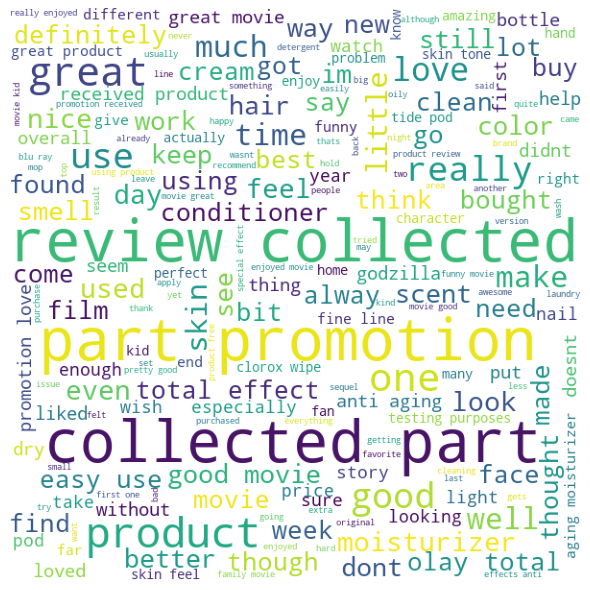

In [69]:
# Frecuencia de palabras
# Wordcloud de las palabras de rating = 4
words = ' '.join(rated_4['reviews.text'])

wordcloud = WordCloud(width = 600,
                      height = 600,
                      background_color ='white'
                    ).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

<BarContainer object of 10 artists>

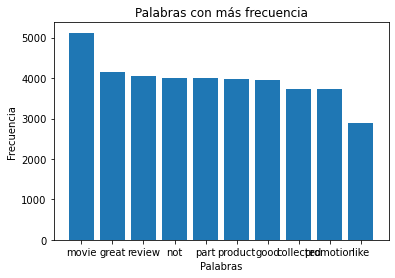

In [70]:
words_ = words.split()
counts = Counter(words_)

# función que calcula la cantidad de veces que aparece cada palabra en el dataset. 
def word_counter(cleaned_words):
    word_counter = {}
    for word in cleaned_words:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    return word_counter

# Histograma de palabras mas frecuentes
word_counter = word_counter(words_)

word_counter_sorted_4 = sorted(word_counter.items(), key=lambda x:x[1],reverse=True)

word_dict_4 = dict(word_counter_sorted_4[0:10])
keys = word_dict_4.keys()
values = word_dict_4.values()
plt.title("Palabras con más frecuencia")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

### Rating = 5

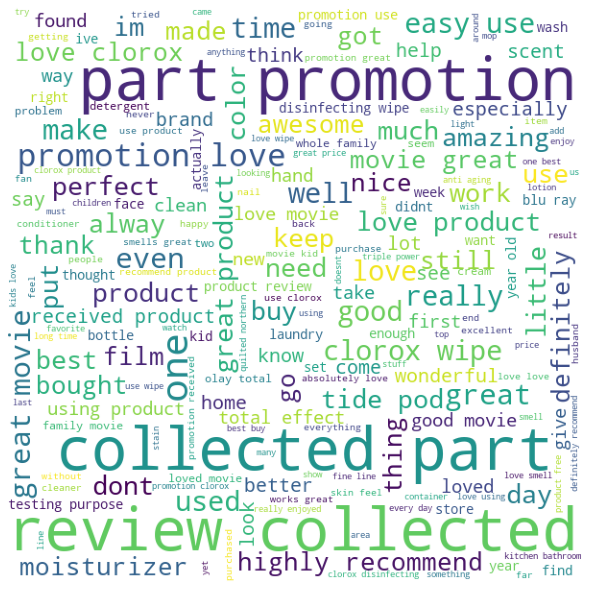

In [75]:
# Frecuencia de palabras
# Wordcloud de las palabras de rating = 5
words = ' '.join(rated_5['reviews.text'])

wordcloud = WordCloud(width = 600,
                      height = 600,
                      background_color ='white'
                    ).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

<BarContainer object of 10 artists>

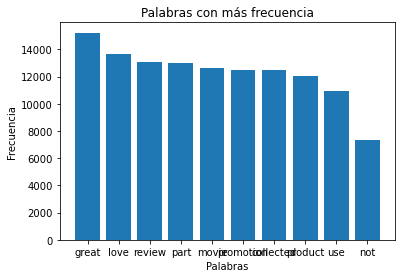

In [106]:
words_ = words.split()
counts = Counter(words_)

# función que calcula la cantidad de veces que aparece cada palabra en el dataset. 
def word_counter(cleaned_words):
    word_counter = {}
    for word in cleaned_words:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1
    return word_counter


# Histograma de palabras mas frecuentes
word_counter = word_counter(words_)

word_counter_sorted_5 = sorted(word_counter.items(), key=lambda x:x[1],reverse=True)

word_dict_5 = dict(word_counter_sorted_5[0:10])
keys = word_dict_5.keys()
values = word_dict_5.values()
plt.title("Palabras con más frecuencia")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

### Palabras presentes en todos los reviews

In [91]:
repeated_words = []

In [93]:
for word in dict(word_counter_sorted_5).keys():
    if word in dict(word_counter_sorted_4).keys():
        if word in dict(word_counter_sorted_3).keys():
            if word in dict(word_counter_sorted_2).keys():
                if word in dict(word_counter_sorted_1).keys():
                    repeated_words.append((word, dict(word_counter_sorted_5).get(word) + dict(word_counter_sorted_4).get(word) + dict(word_counter_sorted_3).get(word) + dict(word_counter_sorted_2).get(word) + dict(word_counter_sorted_1).get(word)))

<BarContainer object of 10 artists>

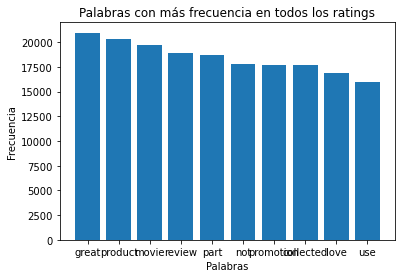

In [104]:
top_10_repetidas = sorted(repeated_words,key=lambda x:x[1], reverse=True)[0:10]
keys = dict(top_10_repetidas).keys()
values = dict(top_10_repetidas).values()
plt.title("Palabras con más frecuencia en todos los ratings")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.bar(keys, values)

## Generación de sentiment analysis del dataset

In [28]:
# Union de la columna de los reviews de las personas
comments = " ".join(data["reviews.text"])

In [53]:
# Seleccion de columnas importantes
clean = data[['name', 'manufacturer','reviews.text', 'reviews.title', 'reviews.rating', 'reviews.username', "categories"]]

In [54]:
import operator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# Funcion que obtiene el sentimiento con mayor porcentaje
def get_sentiment(sentence):
    score = analyser.polarity_scores(sentence)
    score.pop('compound', None)
    sentiment = max(score.items(), key=operator.itemgetter(1))[0]
    max_sent = "positive" if sentiment == "pos" else "negative" if sentiment == "neg" else "neutral"
    return max_sent

In [55]:
# Obtener los sentimientos de cada fila
clean['sentiment'] = clean['reviews.text'].map(lambda x: get_sentiment(x))

<ipython-input-55-bf373e57e0fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['sentiment'] = clean['reviews.text'].map(lambda x: get_sentiment(x))


## Resultados

#### ¿Cuáles son los 10 productos de mejor calidad dado su review?

In [56]:
# se obtiene la cuenta de cuántos reviews positivos, negativos y neutros hay para cada producto. 
sentiment_count = clean.groupby(["name", "sentiment"]).size().reset_index(name='counts')

In [33]:
sentiment_count[sentiment_count["sentiment"] == "positive"].sort_values(["counts"], ascending=False).head(10)

,name,sentiment,counts
998,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,positive,3248
223,Clorox Disinfecting Wipes Value Pack Scented 1...,positive,1935
379,Independence Day Resurgence (4k/uhd + Blu-Ray ...,positive,1479
985,The Jungle Book (blu-Ray/dvd + Digital),positive,1308
310,Godzilla 3d Includes Digital Copy Ultraviolet ...,positive,1295
937,Storks (blu-Ray),positive,866
220,Clorox Disinfecting Bathroom Cleaner,positive,731
756,Planes: Fire Rescue (2 Discs) (includes Digita...,positive,639
1008,Tide Original Liquid Laundry Detergent - 100 Oz,positive,569
839,Sausage Party (4k/uhd + Digital),positive,536


#### ¿Cuáles son los 10 productos de menor calidad dado su review?

In [34]:
sentiment_count[sentiment_count["sentiment"] == "negative"].sort_values(["counts"], ascending=False).head(10)

,name,sentiment,counts
377,Independence Day Resurgence (4k/uhd + Blu-Ray ...,negative,120
308,Godzilla 3d Includes Digital Copy Ultraviolet ...,negative,49
837,Sausage Party (4k/uhd + Digital),negative,41
573,Mike Dave Need Wedding Dates (dvd + Digital),negative,21
617,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,negative,18
996,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,negative,18
820,Rubbermaid174 Reveal Spray Mop,negative,17
988,The Resident Evil Collection 5 Discs (blu-Ray),negative,17
655,Nexxus Exxtra Gel Style Creation Sculptor,negative,15
1006,Tide Original Liquid Laundry Detergent - 100 Oz,negative,11


#### ¿Cuáles son los usuarios que dan la mayor cantidad de reviews a distintos productos?

In [35]:
user_reviews = clean.groupby(["reviews.username", "name"]).size().reset_index(name='counts')

In [36]:
user_sorted = user_reviews.sort_values(["counts"], ascending=False).head(30)
user_sorted["reviews.username"] = user_sorted["reviews.username"].str.lower()
user_sorted[~user_sorted["reviews.username"].str.contains("anonymous")]

,reviews.username,name,counts
9086,chris,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,23
6477,byamazon customer,Aveeno Baby Continuous Protection Lotion Sunsc...,22
6479,byamazon customer,"Lundberg Wehani Rice, 25lb",19
29426,mike,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,19
6480,byamazon customer,"Maybelline Eye Studio Color Plush Shadow Quad,...",14
11509,dave,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,14
29412,mike,Independence Day Resurgence (4k/uhd + Blu-Ray ...,13
29411,mike,Godzilla 3d Includes Digital Copy Ultraviolet ...,12
21117,john,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,12
36319,rich,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,9


#### ¿Cuáles son los usuarios que más reviews negativos y positivos dan en promedio?

In [62]:
avg_revs = clean[clean["sentiment"] != "neutral"]
avg_reviews = avg_revs.groupby(["reviews.username", "sentiment"]).size().reset_index(name='counts')

In [63]:
positives = avg_reviews[avg_reviews.sentiment == "positive"]
positives.sort_values(["counts"], ascending=False).head(10)

,reviews.username,sentiment,counts
582,An anonymous customer,positive,100
7859,Mike,positive,45
2490,Chris,positive,39
3109,Dave,positive,28
1778,ByAmazon Customer,positive,23
5733,John,positive,21
695,Anonymous,positive,20
5268,James,positive,15
9778,Rick,positive,14
625,Angel,positive,14


In [65]:
negatives = avg_reviews[avg_reviews.sentiment == "negative"]
negatives.sort_values(["counts"], ascending=False).head(10)

,reviews.username,sentiment,counts
1777,ByAmazon Customer,negative,4
581,An anonymous customer,negative,3
1440,Bnmorgan,negative,2
5267,James,negative,2
7858,Mike,negative,2
14979,joshandles,negative,2
6071,Kalchi,negative,2
9205,Pepper,negative,2
2483,ChooseZMom,negative,2
8686,Nexxus Customer,negative,2


#### ¿Cuáles son los productores que tienen productos de mejor calidad?

In [58]:
positives = clean[clean.sentiment == "positive"]
products_by_producers = positives.groupby(["manufacturer", "sentiment","categories"]).size().reset_index(name='counts')
products_by_producers.sort_values(["counts"], ascending=False).head(20)

,manufacturer,sentiment,categories,counts
407,Universal,positive,"Featured Brands,Character Shop,The Secret Life...",3248
67,Clorox,positive,"Household Essentials,Cleaning Supplies,Kitchen...",1935
395,Twentieth Century Fox,positive,"Movies, Music & Books,Movies,Action & Adventur...",1479
44,Buena Vista,positive,"Movies, Music & Books,Ways To Shop Entertainme...",1308
373,Test,positive,"Movies, Music & Books,Movies,Action & Adventur...",1295
429,WarnerBrothers,positive,"Movies, Music & Books,Ways To Shop Entertainme...",866
12,AmazonUs/CLOO7,positive,"Household Chemicals,Household Cleaners,Bath & ...",731
424,Walt Disney,positive,"Movies, Music & Books,Movies,Kids' & Family,Wa...",639
294,Procter & Gamble,positive,"Household Essentials,Ways To Shop,Household Es...",569
346,Sony Pictures,positive,"Movies, Music & Books,Movies,Comedy,Movies & T...",536


#### ¿Cuáles son los productores que tienen productos de peor calidad?

In [57]:
negative = clean[clean.sentiment == "negative"]
products_by_producers = negative.groupby(["manufacturer", "sentiment","categories"]).size().reset_index(name='counts')
products_by_producers.sort_values(["counts"], ascending=False).head(20)

,manufacturer,sentiment,categories,counts
81,Twentieth Century Fox,negative,"Movies, Music & Books,Movies,Action & Adventur...",120
75,Test,negative,"Movies, Music & Books,Movies,Action & Adventur...",49
69,Sony Pictures,negative,"Movies, Music & Books,Movies,Comedy,Movies & T...",41
80,Twentieth Century Fox,negative,"Movies & TV Shows,Movies,Romance,Romantic Come...",21
84,Universal,negative,"Movies, Music & Books,Movies,Comedy,Movies & T...",18
83,Universal,negative,"Featured Brands,Character Shop,The Secret Life...",18
64,SONY CORP,negative,"Movies, Music & Books,Ways To Shop Entertainme...",17
63,Rubbermaid,negative,"Household Essentials,Cleaning Supplies,Cleanin...",17
51,Nexxus Beauty Products,negative,"Personal Care,Hair Care,Styling Gel/Lotion,Bea...",15
60,Procter & Gamble,negative,"Household Essentials,Ways To Shop,Household Es...",11


## Propuesta
#### ¿Qué le propondría a esta empresa para mejorar sus productos?

Una observación importante es que el caso de aquellos productores en donde sus productos caen en la categoría de películas y música, las personas usualmente realizan reviews y comentarios sobre las películas y/o canciones y sobre si les gustó o no, no realizan comentarios sobre la calidad del producto en sí. Por tanto, el sentiment de los reviews - y si los clientes perciben el producto como "bueno" o "malo" - realmente no depende de los procesos de "manufactura" de la empresa; por lo que lo más que pueden hacer es intentar realizar contenido de mejor calidad.

Una de las estrategias que se pueden tomar - y que en la realidad ya se ha implementado por distintas empresas, como eBay, Coffee Gator y más - es, en el caso en donde los clientes no han recibido lo que esperaban - ya sea porque no les gustó, porque era completamente diferente o porque ha llegado dañado, es reponer el ítem por algún otro o incluso reemplazarlo. De esta manera, se puede cambiar el sentimiento de un futuro review del usuario. 

Otra recomendación que se podría realizar es incitar a la empresa a observar que productos son los que se venden menos, hacer un sentiment analysis y wordclouds de dichos productos para determinar los aspectos clave del producto que no cumplen con las expectativas del cliente y así intentar remediarlos lo más pronto posible, para no perder más ventas.